In [1]:
import json
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from collections import Counter

%load_ext autoreload
%autoreload 2

# Change the working directory to the root of the GitHub repository
notebook_dir = os.getcwd()
if "ranking" in notebook_dir:
    os.chdir(os.path.dirname(os.path.abspath(notebook_dir)))
    print(f"Changed working directory to: {os.getcwd()}")

# Load JSONL files
def load_jsonl(file_path):
    with open(file_path, 'r') as file:
        return [json.loads(line) for line in file]

# File paths
train_file_path = 'ranking_dataset/mistral-base-train-1108935.jsonl'
test_file_path = 'ranking_dataset/mistral-base-test-1096727.jsonl'

# Load data
train_data = load_jsonl(train_file_path)
test_data = load_jsonl(test_file_path)

# Prepare train, validation, and test splits
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")
# Display all the keys in the dataset
print("Keys in data:", train_data[0].keys())
print("keys in candidates:", train_data[0]['candidates'][0].keys())

print("Keys in data:", test_data[0].keys())
print("keys in candidates:", test_data[0]['candidates'][0].keys())

### change a key.
# Update the key 'input' to 'input_token' in test_data
for entry in test_data:
    if 'input' in entry:
        entry['input_token'] = entry.pop('input')


Changed working directory to: /home/bowenson/Github/CoT-Rec
Training data size: 5856
Validation data size: 1464
Test data size: 1319
Keys in data: dict_keys(['candidates', 'input_token', 'attention_mask', 'answer_scores', 'answer', 'is_correct'])
keys in candidates: dict_keys(['text', 'answer', 'answer_span', 'score', 'output_tokens'])
Keys in data: dict_keys(['candidates', 'input_token', 'attention_mask', 'answer_scores', 'answer', 'is_correct'])
keys in candidates: dict_keys(['text', 'answer', 'answer_span', 'score', 'output_tokens'])


In [2]:
def format_dataset(data):
    formatted_dataset = {
        "input_tokens": [],
        "output_tokens": [],
        "scores": []
    }
    for entry in data:
        input_tokens = entry['input_token']
        candidates = entry['candidates']
        answer = entry['answer']

        output_tokens_list = [[candidate['score']]+[candidate['answer']]+candidate['output_tokens'] for candidate in candidates]
        scores_list = [1 if candidate['answer'] == answer else 0 for candidate in candidates]

        formatted_dataset["input_tokens"].append(input_tokens)
        formatted_dataset["output_tokens"].append(output_tokens_list)
        formatted_dataset["scores"].append(scores_list)

    return pd.DataFrame(formatted_dataset)

df_train = format_dataset(train_data)
df_validation = format_dataset(val_data)
df_test = format_dataset(test_data)



In [3]:
# Example output
print(f"Example formatted dataset entry: {df_train.iloc[0]}")
print(f"Total formatted dataset size: {len(df_train)}")

print(df_train['scores'].tolist())
print([d[0][-1] for d in df_train['output_tokens'].tolist()])

Example formatted dataset entry: input_tokens     [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
output_tokens    [[0.47398239374160767, 300, 28705, 28770, 2873...
scores           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
Name: 0, dtype: object
Total formatted dataset size: 5856
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [4]:
from copy import deepcopy

def convert_maxvote(df, items=50):
    df_copy = df.copy(deep=True)
    df_copy['output_tokens'] = deepcopy(df['output_tokens'].tolist())
    df_copy['output_tokens'] = df_copy['output_tokens'].apply(lambda d: d[:items])

    for i in range(len(df_copy['output_tokens'])):
        answer_counts = Counter([candidate[1] for candidate in df_copy['output_tokens'][i]])
        for j in range(len(df_copy['output_tokens'][i])):
            # Update the last element with the count
            df_copy['output_tokens'][i][j][1] = answer_counts.get(df_copy['output_tokens'][i][j][1], 0)
    return df_copy
df_train = convert_maxvote(df_train)
df_validation = convert_maxvote(df_validation)
# df_test_vote = convert_maxvote(df_test)



In [5]:
# from copy import deepcopy

# def convert_weightedmaxvote(df, items=50):
#     df_copy = df.copy(deep=True)
#     df_copy['output_tokens'] = deepcopy(df['output_tokens'].tolist())
#     df_copy['output_tokens'] = df_copy['output_tokens'].apply(lambda d: d[:items])

#     for i in range(len(df_copy['output_tokens'])):
#         _temp = [candidate[:2] for candidate in df_copy['output_tokens'][i]]
#         weighted_sum = {}
#         for score, answer in _temp:
#             if answer not in weighted_sum:
#                 weighted_sum[answer] = 0
#             weighted_sum[answer] += score
#         for j in range(len(df_copy['output_tokens'][i])):
#             df_copy['output_tokens'][i][j][1] = weighted_sum[df_copy['output_tokens'][i][j][1]]
        
#     for i in range(len(df_copy['output_tokens'])):
#         for j in range(len(df_copy['output_tokens'][i])):
#             df_copy['output_tokens'][i][j] = df_copy['output_tokens'][i][j][1:]

#     return df_copy

# df_train = convert_weightedmaxvote(df_train, items=50)
# df_validation = convert_weightedmaxvote(df_validation, items=50)
# df_test = convert_weightedmaxvote(df_test, items=10)



In [6]:
from ranking.xgboost_ranker import XGBoostRanker,RankingMetrics

# Initialize the XGBoost ranker
ranker = XGBoostRanker(objective='rank:map',eval_metric='map@1')
# Train the model
ranker.train(
    df_train['input_tokens'].tolist(),
    df_train['output_tokens'].tolist(),
    df_train['scores'].tolist(),
    (df_validation['input_tokens'].tolist(),
    df_validation['output_tokens'].tolist(),
    df_validation['scores'].tolist())
)
# Evaluate the model
# predictions = ranker.predict(
#     df_test['input_tokens'].tolist(),
#     df_test['output_tokens'].tolist()
# )

# true_scores_flat = [score for group in df_test['scores'] for score in group]
# predictions_flat = [pred for group in predictions for pred in group]
# metrics = RankingMetrics.calculate_metrics(true_scores_flat, predictions_flat)

# print("Metrics:", metrics)
# acc = [entry['candidates'][np.argmax(pred)]['answer'] == entry['answer'] for pred, entry in zip(predictions, test_data)]
# print("Accuracy:", np.mean(acc))

Using CPU for training.
[0]	validation-map@1:0.29986
[1]	validation-map@1:0.30260
[2]	validation-map@1:0.34290
[3]	validation-map@1:0.35656
[4]	validation-map@1:0.38115
[5]	validation-map@1:0.39959
[6]	validation-map@1:0.40847
[7]	validation-map@1:0.42350
[8]	validation-map@1:0.42828
[9]	validation-map@1:0.43443
[10]	validation-map@1:0.44194
[11]	validation-map@1:0.45287
[12]	validation-map@1:0.46038
[13]	validation-map@1:0.46311
[14]	validation-map@1:0.46790
[15]	validation-map@1:0.46448
[16]	validation-map@1:0.47336
[17]	validation-map@1:0.47473
[18]	validation-map@1:0.47404
[19]	validation-map@1:0.48292
[20]	validation-map@1:0.48770
[21]	validation-map@1:0.49590
[22]	validation-map@1:0.50000
[23]	validation-map@1:0.50205
[24]	validation-map@1:0.50615
[25]	validation-map@1:0.51571
[26]	validation-map@1:0.51571
[27]	validation-map@1:0.51571
[28]	validation-map@1:0.52254
[29]	validation-map@1:0.52596
[30]	validation-map@1:0.52527
[31]	validation-map@1:0.53484
[32]	validation-map@1:0.54

In [7]:
# param_grid = {
#     "eta": [0.01, 0.1],
#     "max_depth": [3, 6, 10],
#     "min_child_weight": [1, 3],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0],
#     "lambda": [1, 5],
#     "alpha": [0, 1],
#     "objective": ["rank:pairwise", "rank:map"],
#     "eval_metric": ["map@1"]
# }



# ranker = XGBoostRanker()
# ranker,_ = ranker.hyperparameter_search(
#         (df_train['input_tokens'].tolist(),
#     df_train['output_tokens'].tolist(),
#     df_train['scores'].tolist())
#     , (df_validation['input_tokens'].tolist(),
#     df_validation['output_tokens'].tolist(),
#     df_validation['scores'].tolist())
#     , param_grid)

   top_k  max_prob  max_vote  max_probsum  top_recomm  correct_included
0      1  0.233510  0.233510     0.233510    0.233510          0.233510
1      5  0.295679  0.317665     0.363154    0.331312          0.617892
2     10  0.288855  0.348749     0.481425    0.385898          0.821835
3     20  0.295679  0.463230     0.655800    0.498863          0.963609
4     30  0.278999  0.527672     0.783927    0.539045          0.998484
5     40  0.249431  0.539045     0.853677    0.549659          1.000000
6     50  0.224412  0.535254     1.000000    0.590599          1.000000


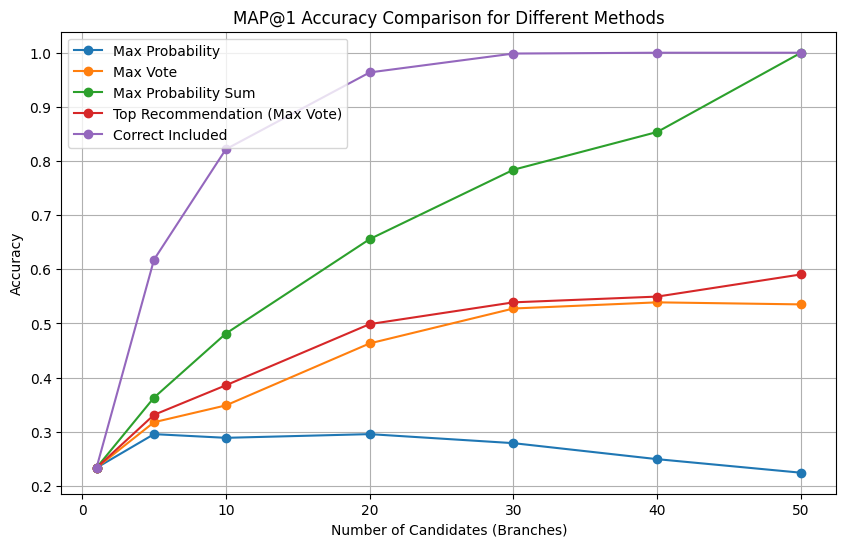

In [8]:
from cot_dataset.cot_decoding.task import GSMTask
import pandas as pd

task = GSMTask(encode_format='qa')
results = []

for top_k in [1, 5, 10, 20, 30, 40, 50]:
    max_prob = []
    max_vote = []
    max_probsum = []
    top_recomm = []
    correct_included = []

    df_test_vote = convert_maxvote(df_test, items=top_k)

    predictions = ranker.predict(
        df_test_vote['input_tokens'].tolist(),
        [entry[:top_k] for entry in df_test_vote['output_tokens']],
    )

    for entry, pred in zip(test_data, predictions):
        scores = []
        for can in entry['candidates'][:top_k]:
            scores.append((can['answer'], can['score']))
        max_prob.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])

        correct_included.append(
            any([can['answer'] == entry['answer'] for can in entry['candidates'][:top_k]])
        )

        # Count the occurrences of each answer, if there is a tie, take the one with the highest score
        votes = Counter([can['answer'] for can in entry['candidates'][:top_k]])
        most_common_vote = votes.most_common(1)[0]
        if most_common_vote[1] == 1:
            max_vote.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])
        else:
            max_vote.append(most_common_vote[0] == entry['answer'])

        # Sum the scores for each answer
        score_sums = {}
        for can in entry['candidates'][:top_k]:
            score_sums[can['answer']] = score_sums.get(can['answer'], 0) + can['score']
        max_probsum.append(max(score_sums, key=score_sums.get) == entry['answer'])

        top_recomm.append(entry['candidates'][np.argmax(pred[:top_k])]['answer'] == entry['answer'])

    results.append({
        "top_k": top_k,
        "max_prob": sum(max_prob) / len(max_prob),
        "max_vote": sum(max_vote) / len(max_vote),
        "max_probsum": sum(max_probsum) / len(max_probsum),
        "top_recomm": sum(top_recomm) / len(top_recomm),
        "correct_included": sum(correct_included) / len(correct_included),
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['top_k'], results_df['max_prob'], label='Max Probability', marker='o')
plt.plot(results_df['top_k'], results_df['max_vote'], label='Max Vote', marker='o')
plt.plot(results_df['top_k'], results_df['max_probsum'], label='Max Probability Sum', marker='o')
plt.plot(results_df['top_k'], results_df['top_recomm'], label='Top Recommendation (Max Vote)', marker='o')
plt.plot(results_df['top_k'], results_df['correct_included'], label='Correct Included', marker='o')

plt.xlabel('Number of Candidates (Branches)')
plt.ylabel('Accuracy')
plt.title('MAP@1 Accuracy Comparison for Different Methods')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# train_data = load_jsonl(train_file_path)
# test_data = load_jsonl(test_file_path)

# # Prepare train, validation, and test splits
# train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
# ### change a key.
# Update the key 'input' to 'input_token' in test_data
for entry in test_data:
    if 'input' in entry:
        entry['input_token'] = entry.pop('input')
# second set of dataset
def format_dataset(data):
    formatted_dataset = {
        "input_tokens": [],
        "output_tokens": [],
        "scores": []
    }
    for entry in data:
        input_tokens = entry['input_token']
        candidates = entry['candidates']
        answer = entry['answer']

        # print("input_tokens:", input_tokens)
        # print("candidates:", candidates[0]['output_tokens'])
        # print("answer:", answer)

        output_tokens_list = [candidate['output_tokens']+[candidate['score']]+[candidate['answer']] for candidate in candidates]
        scores_list = [1 if candidate['answer'] == answer else 0 for candidate in candidates]

        formatted_dataset["input_tokens"].append(input_tokens)
        formatted_dataset["output_tokens"].append(output_tokens_list)
        formatted_dataset["scores"].append(scores_list)
        # break


    return pd.DataFrame(formatted_dataset)

df_train = format_dataset(train_data)
df_validation = format_dataset(val_data)
df_test = format_dataset(test_data)

# Example output
print(f"Example formatted dataset entry: {df_train.iloc[0]}")
print(f"Total formatted dataset size: {len(df_train)}")

print(df_train['scores'].tolist())
print([_d[0][-1] for _d in df_test['output_tokens']])


In [ ]:
# from ranking.xgboost_ranker import XGBoostRanker,RankingMetrics

# # Initialize the XGBoost ranker
# ranker = XGBoostRanker(objective='rank:map',eval_metric='map@1')
# # Train the model
# ranker.train(
#     df_train['input_tokens'].tolist(),
#     df_train['output_tokens'].tolist(),
#     df_train['scores'].tolist(),
#     (df_validation['input_tokens'].tolist(),
#     df_validation['output_tokens'].tolist(),
#     df_validation['scores'].tolist())
# )
# # Evaluate the model
# predictions = ranker.predict(
#     df_test['input_tokens'].tolist(),
#     df_test['output_tokens'].tolist()
# )

# true_scores_flat = [score for group in df_test['scores'] for score in group]
# predictions_flat = [pred for group in predictions for pred in group]
# metrics = RankingMetrics.calculate_metrics(true_scores_flat, predictions_flat)

# print("Metrics:", metrics)
# acc = [entry['candidates'][np.argmax(pred)]['answer'] == entry['answer'] for pred, entry in zip(predictions, test_data)]
# print("Accuracy:", np.mean(acc))

from cot_dataset.cot_decoding.task import GSMTask
from collections import Counter
import pandas as pd

task = GSMTask(encode_format='qa')



results = []

for top_k in [1, 5, 10, 20, 30, 40, 50]:
    max_prob = []
    max_vote = []
    max_probsum = []
    top_recomm = []
    correct_included = []

    predictions = ranker.predict(
        df_test['input_tokens'].tolist(),
        [entry[:top_k] for entry in df_test['output_tokens']],
    )

    for entry, pred in zip(test_data, predictions):
        scores = []
        for can in entry['candidates'][:top_k]:
            scores.append((can['answer'], can['score']))
        max_prob.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])

        correct_included.append(
            any([can['answer'] == entry['answer'] for can in entry['candidates'][:top_k]])
        )

        # Count the occurrences of each answer, if there is a tie, take the one with the highest score
        votes = Counter([can['answer'] for can in entry['candidates'][:top_k]])
        most_common_vote = votes.most_common(1)[0]
        if most_common_vote[1] == 1:
            max_vote.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])
        else:
            max_vote.append(most_common_vote[0] == entry['answer'])

        # Sum the scores for each answer
        score_sums = {}
        for can in entry['candidates'][:top_k]:
            score_sums[can['answer']] = score_sums.get(can['answer'], 0) + can['score']
        max_probsum.append(max(score_sums, key=score_sums.get) == entry['answer'])

        top_recomm.append(entry['candidates'][np.argmax(pred[:top_k])]['answer'] == entry['answer'])

    results.append({
        "top_k": top_k,
        "max_prob": sum(max_prob) / len(max_prob),
        "max_vote": sum(max_vote) / len(max_vote),
        "max_probsum": sum(max_probsum) / len(max_probsum),
        "top_recomm": sum(top_recomm) / len(top_recomm),
        "correct_included": sum(correct_included) / len(correct_included),
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['top_k'], results_df['max_prob'], label='Max Probability', marker='o')
plt.plot(results_df['top_k'], results_df['max_vote'], label='Max Vote', marker='o')
plt.plot(results_df['top_k'], results_df['max_probsum'], label='Max Probability Sum', marker='o')
plt.plot(results_df['top_k'], results_df['top_recomm'], label='Top Recommendation (Max Vote)', marker='o')
plt.plot(results_df['top_k'], results_df['correct_included'], label='Correct Included', marker='o')

plt.xlabel('Number of Candidates (Branches)')
plt.ylabel('Accuracy')
plt.title('MAP@1 Accuracy Comparison for Different Methods')
plt.legend()
plt.grid(True)
plt.show()
